In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')

def load_cifar():
    from tensorflow.keras.datasets import cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return (x_train, y_train), (x_test, y_test)
    
(x_train, y_train), (x_test, y_test) = load_cifar()


(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [3]:
# from capsnet.capsnet import CapsNet
from cifar.cifar_capsnet import CapsNetCifar

ROUTINGS = 3
BATCH_SIZE = 100
INPUT_SHAPE = (32, 32, 3)
N_CLASS = 10

model, eval_model, manipulate_model = CapsNetCifar(input_shape=INPUT_SHAPE,
                                                   n_class=N_CLASS,
                                                   routings=ROUTINGS,
                                                   batch_size=BATCH_SIZE)
model.summary()


starting CapsNetCifar (32, 32, 3) 10 3 100
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(100, 32, 32, 3)]   0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (100, 28, 28, 32)    2432        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (100, 28, 28, 32)    128         conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (100, 26, 26, 64)    18496       batch_normalization_8[0][0]      
_________________________________________________

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    mean = tf.reduce_mean(tf.reduce_sum(L, 1))
    return mean


lr = 0.001
lam_recon = 0.392
# compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                loss=[margin_loss, 'mse'],
                loss_weights=[1., lam_recon],
                metrics={'capsnet': 'accuracy'})
# tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)


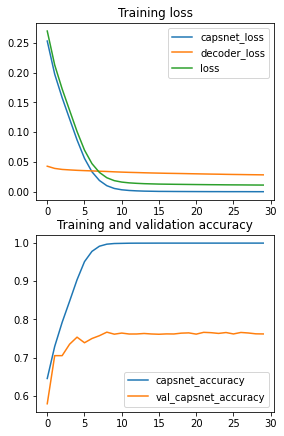

In [14]:
from utils.utils import combine_images, plot_log
from metrics import get_callbacks
run_fit = False
save_dir='./result/capsnet_cifar/capsnet_cifar_modif-05-15'
weights = save_dir + '/trained_model.h5'

def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        for next_generated in generator:
            yield (next_generated[0], next_generated[1]), (next_generated[1], next_generated[0])

net_callbacks = get_callbacks(save_dir, lr)
if(run_fit):
    model.fit(train_generator(x_train, y_train, BATCH_SIZE),
                steps_per_epoch=int(y_train.shape[0] / BATCH_SIZE),
                epochs=30,
                validation_data=((x_test, y_test), (y_test, x_test)),
                batch_size=BATCH_SIZE,
                callbacks=[net_callbacks])
    model.save_weights(save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % save_dir)
else:
    model.load_weights(weights)

plot_log(save_dir + '/log.csv', show=True)

#TODO:
# add visualisation of some layers (capsules and conv)
# make sequential model and load the weights

(5, 5, 3, 32) (32,)
-0.24318905 0.20763648
0.0 1.0


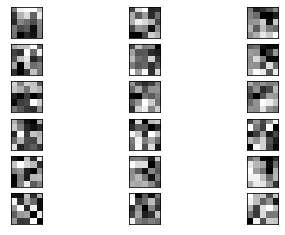

In [15]:
import matplotlib.pyplot as plt

conv_layer = model.layers[1]
filters, biases = conv_layer.get_weights()
print(filters.shape, biases.shape)
def print_filter(filters):
	f_min, f_max = filters.min(), filters.max()
	print(f_min, f_max)
	filters = (filters - f_min) / (f_max - f_min)
	f_min, f_max = filters.min(), filters.max()
	print(f_min, f_max)

	n_filters, ix = 6, 1
	for i in range(n_filters):
		# get the filter
		f = filters[:, :, :, i]
		
		# plot each channel separately
		for j in range(3):
			# specify subplot and turn of axis
			ax = plt.subplot(n_filters, 3, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(f[:, :, j], cmap='gray')
			ix += 1
	# show the figure
	plt.show()
print_filter(filters)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002A6F0F923D0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002A6F0F92B50>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000002A6FE845D30>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002A6FE94DA00>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000002A6A5FC6250>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002A6A5CD2E80>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000002A6B44DC8E0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002A6B4518340>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000002A6B45011C0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002A6B4516D90>, <tensorflow.python.keras.layers.core.Reshape object at 0x000002A6B44E55B0>, <tensorflow.python.ke

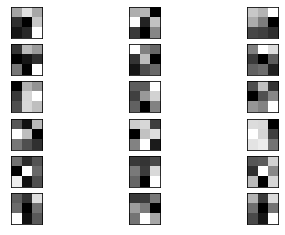

In [12]:
print(model.layers)
conv_layer = model.layers[3]
filters, biases = conv_layer.get_weights()
filters.shape
print_filter(filters)

------------------------------Begin: test------------------------------
Reconstructed images are saved to ./result/capsnet_cifar/capsnet_cifar_modif-05-15/images_eval.png
------------------------------End: test------------------------------


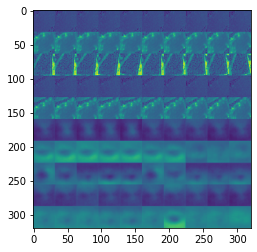

------------------------------Begin: test------------------------------
Reconstructed images are saved to ./result/capsnet_cifar/capsnet_cifar_modif-05-15/x_test.png
------------------------------End: test------------------------------


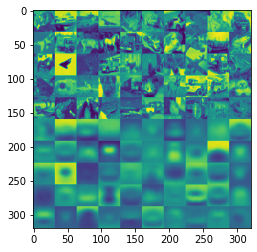

In [16]:
from images import get_images_eval, predict_and_print, create_batch, images_train, images_valid, images_test, preprocess_image_with_angle

images_eval = get_images_eval()

predict_and_print(save_dir, eval_model, images_eval, "images_eval")
predict_and_print(save_dir, eval_model, x_test, "x_test")
